[https://openclassrooms.com/fr/paths/164/projects/627/assignment](https://openclassrooms.com/fr/paths/164/projects/627/assignment)



## Preamble



In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

ModuleNotFoundError: No module named 'seaborn'

## Objectifs

Déterminer si les [données sur l’éducation de la banque mondiale](https://datacatalog.worldbank.org/dataset/education-statistics) permettent
d’informer le projet d’expansion de l'entreprise.

-   Quels sont les pays avec un fort potentiel de clients pour nos services ?
-   Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
-   Dans quels pays l'entreprise doit-elle opérer en priorité ?



## Analyse exploratoire

-   Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données
    manquantes, dupliquées ?)
-   Décrire les informations contenues dans le jeu de données (nombre de colonnes
    ? nombre de lignes ?)
-   Sélectionner les informations qui semblent pertinentes pour répondre à la
    problématique (quelles sont les colonnes contenant des informations qui
    peuvent être utiles pour répondre à la problématique de l’entreprise ?)
-   Déterminer des ordres de grandeurs des indicateurs statistiques classiques
    pour les différentes zones géographiques et pays du monde
    (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)



### Loading Data

In [3]:
ed_sets = {'country_series': 'EdStatsCountry-Series.csv',
           'foot_note': 'EdStatsFootNote.csv',
           'country': 'EdStatsCountry.csv',
           'series': 'EdStatsSeries.csv',
           'data': 'EdStatsData.csv'}

In [4]:
for key, val in ed_sets.items():
    exec("file = 'data/" + val + "'")
    exec(key + "= pd.read_csv(file)")
    print("--- " + val)
    exec("print(" + key + ".shape)")
    exec("print(" + key + ".isna().sum())")

--- EdStatsCountry-Series.csv
(613, 4)
CountryCode      0
SeriesCode       0
DESCRIPTION      0
Unnamed: 3     613
dtype: int64
--- EdStatsFootNote.csv
(643638, 5)
CountryCode         0
SeriesCode          0
Year                0
DESCRIPTION         0
Unnamed: 4     643638
dtype: int64
--- EdStatsCountry.csv
(241, 32)
Country Code                                           0
Short Name                                             0
Table Name                                             0
Long Name                                              0
2-alpha code                                           3
Currency Unit                                         26
Special Notes                                         96
Region                                                27
Income Group                                          27
WB-2 code                                              1
National accounts base year                           36
National accounts reference year                     

-   We can safely remove the last column of all the datasets:



In [5]:
del data['Unnamed: 69']
del series['Unnamed: 20']
del country['Unnamed: 31']
del foot_note['Unnamed: 4']
del country_series['Unnamed: 3']

-   Do we find every indicator from the series table in our main dataset ?



In [6]:
print(len(data['Indicator Code'].unique()))

3665


-   3665 indicators for 241 countries equals to 883 265, a little less than the
    886 930 rows of our main data. Do we have the same number of countries in the
    latter ?



In [7]:
print(len(data['Country Code'].unique()))

242


Which country is not referenced in the EdStatsCountry data set ?

In [8]:
for i in list(set(data['Country Code'].unique()) - set(country['Country Code'].unique())):
      print(data.loc[data['Country Code'] == i])

                  Country Name Country Code  \
190580  British Virgin Islands          VGB   
190581  British Virgin Islands          VGB   
190582  British Virgin Islands          VGB   
190583  British Virgin Islands          VGB   
190584  British Virgin Islands          VGB   
...                        ...          ...   
194240  British Virgin Islands          VGB   
194241  British Virgin Islands          VGB   
194242  British Virgin Islands          VGB   
194243  British Virgin Islands          VGB   
194244  British Virgin Islands          VGB   

                                           Indicator Name  \
190580  Adjusted net enrolment rate, lower secondary, ...   
190581  Adjusted net enrolment rate, lower secondary, ...   
190582  Adjusted net enrolment rate, lower secondary, ...   
190583  Adjusted net enrolment rate, lower secondary, ...   
190584  Adjusted net enrolment rate, primary, both sex...   
...                                                   ...   
194240  

The British Virgin Islands are the one unidentified country that have data in the EdStatsData set.
As a british territory with only 30.000 inhabitants, it may not be pertinent to keep it in our study as with other such countries...

Some indicators are given by aggregate groups of countries. As we're looking for a country, we discard those indicators.

In [42]:
for i in list(country[country['Region'].isnull()]['Country Code']):
    ids = data[data['Country Code'] == i].index
    data.drop(ids, inplace=True)

We will also discard countries that are provinces or islands with less than 100k inhabitants.

In [48]:
pop = data[data['Indicator Name'] == 'Population, total'][['Country Name', '2015']]
excluded_countries = list(pop[pop['2015'] < 100000]['Country Name'])

for i in excluded_countries:
    ids = data[data['Country Name'] == i].index
    data.drop(ids, inplace=True)

In [49]:
print(len(data['Country Code'].unique()))

196


### Missing values

As we're a french company, we're looking for indicators available equally for france and our target country.

In [50]:
france = data[data['Country Code'] == 'FRA']
indicators = france['Indicator Code'].unique()
years = france[france.columns[4:]]

# There is 3665 indicators
num_ind = years.shape[0]

# There is 65 columns of yearly data
num_years = years.shape[1]

# list of years
years = years.columns

Let's find indicators that are empty or poorly filled

In [78]:
unusable_indicators = []

# filling rate
rate = 0.8
threshold = num_years - round(num_years * rate, 0)

for i in indicators:
    # non missing values by indicator (row)
    na_row = num_years - int(france[france['Indicator Code'] == i].isnull().sum(axis=1))
    if na_row <= threshold:
        unusable_indicators.append(i)
 
num_ind = num_ind - len(unusable_indicators)
print(num_ind)

1000


From now on, we will use a subset of 1000 indicators.

In [72]:
for i in unusable_indicators:
    ids = data[data['Indicator Code'] == i].index
    data.drop(ids, inplace=True)

In [74]:
data.shape

(196000, 69)

196 countries and 1000 indicators for 65 years.

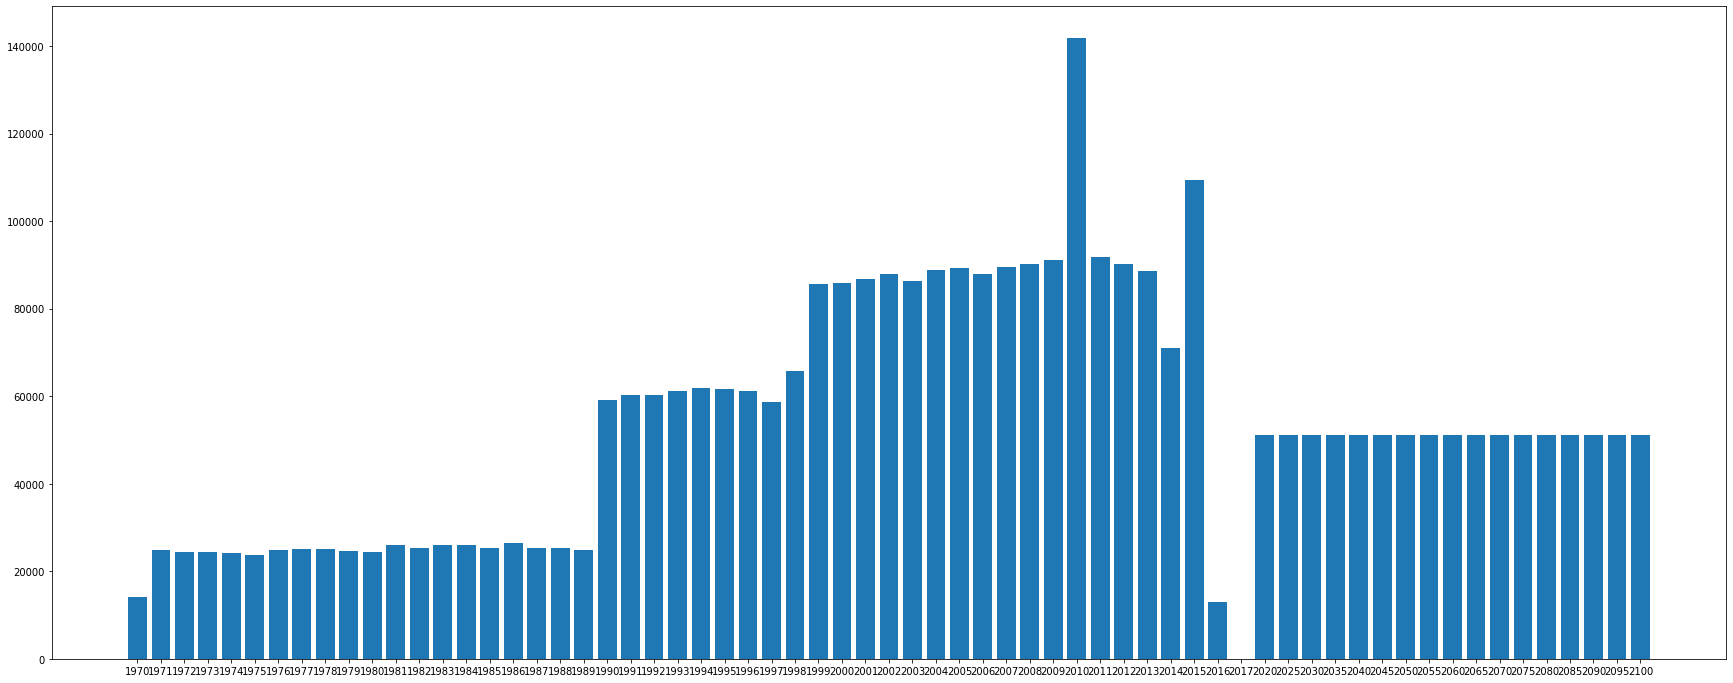

In [80]:
# non missing values by year (column)
na_cols = []
for i in years:
    na_cols.append((num_ind * 196) - int(data[i].isnull().sum(axis=0)))

plt.figure(figsize = (30,12))
plt.bar(years,na_cols)
plt.show()

Indicators are mostly availables for the years between 2000 and 2015. Some indicators are clearly cyclic (by a period of 5 years). Some indicators are consistently filled/forcasted from 2020 to 2100.

??? Do we need old data for our purpose ???

### Tactics

From the remaining data, which indicators are the most interesting to fullfill our mission ?

In [97]:
print(data[data['Indicator Name'].str.contains('')]['Indicator Name'].unique())

['Gross enrolment ratio, lower secondary, both sexes (%)'
 'Gross enrolment ratio, lower secondary, female (%)'
 'Gross enrolment ratio, lower secondary, gender parity index (GPI)'
 'Gross enrolment ratio, lower secondary, male (%)'
 'Gross enrolment ratio, post-secondary non-tertiary, both sexes (%)'
 'Gross enrolment ratio, post-secondary non-tertiary, female (%)'
 'Gross enrolment ratio, post-secondary non-tertiary, gender parity index (GPI)'
 'Gross enrolment ratio, post-secondary non-tertiary, male (%)'
 'Gross enrolment ratio, pre-primary, both sexes (%)'
 'Gross enrolment ratio, pre-primary, female (%)'
 'Gross enrolment ratio, pre-primary, gender parity index (GPI)'
 'Gross enrolment ratio, pre-primary, male (%)'
 'Gross enrolment ratio, primary and lower secondary, both sexes (%)'
 'Gross enrolment ratio, primary and lower secondary, female (%)'
 'Gross enrolment ratio, primary and lower secondary, gender parity index (GPI)'
 'Gross enrolment ratio, primary and lower secondary

In [ ]:
['Expenditure on education as % of total government expenditure (%)',
'Internet users (per 100 people)',
'Personal computers (per 100 people)',
'Population growth (annual %)',
'Population, total',
'Total outbound internationally mobile tertiary students studying abroad, all countries, both sexes (number)']